In [32]:
import os
import numpy as np
import cv2
import xmltodict
import matplotlib.pyplot as plt

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Flatten, Dropout

In [2]:
RAW_PATH_IMAGES = "./archive/images/"
RAW_PATH_IMGDAT = "./archive/annotations/"

In [3]:
RAW_IMAGES = os.listdir(RAW_PATH_IMAGES)
RAW_IMGDAT = os.listdir(RAW_PATH_IMGDAT)

In [8]:
labels = []
faces = []
imgCount = 0

In [22]:
if not os.path.exists("./data/train/without_mask"):
        os.makedirs("./data/train/without_mask")
if not os.path.exists("./data/train/with_mask"):
        os.makedirs("./data/train/with_mask")
if not os.path.exists("./data/train/mask_weared_incorrect"):
        os.makedirs("./data/train/mask_weared_incorrect")

if not os.path.exists("./data/test/without_mask"):
        os.makedirs("./data/test/without_mask")
if not os.path.exists("./data/test/with_mask"):
        os.makedirs("./data/test/with_mask")
if not os.path.exists("./data/test/mask_weared_incorrect"):
        os.makedirs("./data/test/mask_weared_incorrect")

In [23]:
for i in range(len(RAW_IMAGES)):
    with open(os.path.join(RAW_PATH_IMGDAT, RAW_IMGDAT[i]), 'r') as f:
        data = f.read()
        d = xmltodict.parse(data)["annotation"]
        dObject = d["object"]
        img = Image.open(RAW_PATH_IMAGES + RAW_IMAGES[i])
        if isinstance(dObject, list):
            for j in dObject:
                xmin = int(j["bndbox"]["xmin"])
                xmax = int(j["bndbox"]["xmax"])
                ymin = int(j["bndbox"]["ymin"])
                ymax = int(j["bndbox"]["ymax"])
                cropImg = img.crop((xmin, ymin, xmax, ymax))
                resizeImage = cropImg.resize((128, 128), Image.ANTIALIAS)
                if i <= 800:
                    if(j["name"] == "without_mask"):
                        resizeImage.save("./data/train/without_mask/" + str(imgCount) + ".png")
                    elif(j["name"] == "with_mask"):
                        resizeImage.save("./data/train/with_mask/" + str(imgCount) + ".png")
                    else:
                        resizeImage.save("./data/train/mask_weared_incorrect/" + str(imgCount) + ".png")
                else:
                    if(j["name"] == "without_mask"):
                        resizeImage.save("./data/test/without_mask/" + str(imgCount) + ".png")
                    elif(j["name"] == "with_mask"):
                        resizeImage.save("./data/test/with_mask/" + str(imgCount) + ".png")
                    else:
                        resizeImage.save("./data/test/mask_weared_incorrect/" + str(imgCount) + ".png")
                imgCount += 1
        else:
            xmin = int(dObject["bndbox"]["xmin"])
            xmax = int(dObject["bndbox"]["xmax"])
            ymin = int(dObject["bndbox"]["ymin"])
            ymax = int(dObject["bndbox"]["ymax"])
            cropImg = img.crop((xmin, ymin, xmax, ymax))
            resizeImage = cropImg.resize((128, 128), Image.ANTIALIAS)
            if i <= 800:
                if(dObject["name"] == "without_mask"):
                    resizeImage.save("./data/train/without_mask/" + str(imgCount) + ".png")
                elif(dObject["name"] == "with_mask"):
                    resizeImage.save("./data/train/with_mask/" + str(imgCount) + ".png")
                else:
                    resizeImage.save("./data/train/mask_weared_incorrect/" + str(imgCount) + ".png")
            else:
                if(dObject["name"] == "without_mask"):
                    resizeImage.save("./data/test/without_mask/" + str(imgCount) + ".png")
                elif(dObject["name"] == "with_mask"):
                    resizeImage.save("./data/test/with_mask/" + str(imgCount) + ".png")
                else:
                    resizeImage.save("./data/test/mask_weared_incorrect/" + str(imgCount) + ".png")
            imgCount += 1

In [24]:
trainDataGen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
trainingSet = trainDataGen.flow_from_directory("./data/train", target_size = (128, 128), batch_size = 32)

Found 3850 images belonging to 3 classes.


In [25]:
testDataGen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
testingSet = trainDataGen.flow_from_directory("./data/test", target_size = (128, 128), batch_size = 32)

Found 222 images belonging to 3 classes.


In [26]:
trainingSet.class_indices

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, input_shape=(128, 128, 3), activation ='relu', padding = 'Same'))
model.add(Conv2D(32, kernel_size = 3,  activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = 3, activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = 2, strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [28]:
model.compile(loss = "categorical_crossentropy", optimizer='Adamax', metrics=["accuracy"])

In [30]:
metricVals = model.fit(x = trainingSet, validation_data = testingSet, epochs = 35, verbose = 2)

Epoch 1/35
121/121 - 283s - loss: 4.3447 - accuracy: 0.8896 - val_loss: 34.8584 - val_accuracy: 0.1306
Epoch 2/35
121/121 - 282s - loss: 0.7450 - accuracy: 0.9135 - val_loss: 30.1205 - val_accuracy: 0.2568
Epoch 3/35
121/121 - 273s - loss: 0.3563 - accuracy: 0.9275 - val_loss: 13.8351 - val_accuracy: 0.6171
Epoch 4/35
121/121 - 267s - loss: 0.2581 - accuracy: 0.9351 - val_loss: 7.4414 - val_accuracy: 0.6577
Epoch 5/35
121/121 - 260s - loss: 0.2189 - accuracy: 0.9418 - val_loss: 1.4556 - val_accuracy: 0.8604
Epoch 6/35
121/121 - 259s - loss: 0.2200 - accuracy: 0.9392 - val_loss: 0.2660 - val_accuracy: 0.9009
Epoch 7/35
121/121 - 261s - loss: 0.1904 - accuracy: 0.9439 - val_loss: 0.2408 - val_accuracy: 0.9144
Epoch 8/35
121/121 - 259s - loss: 0.1565 - accuracy: 0.9522 - val_loss: 0.3180 - val_accuracy: 0.9279
Epoch 9/35
121/121 - 261s - loss: 0.1648 - accuracy: 0.9535 - val_loss: 0.2182 - val_accuracy: 0.9189
Epoch 10/35
121/121 - 260s - loss: 0.1443 - accuracy: 0.9574 - val_loss: 0.2275

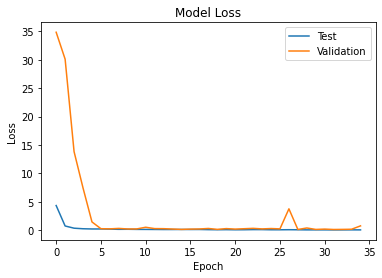

In [33]:
plt.plot(metricVals.history['loss'])
plt.plot(metricVals.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

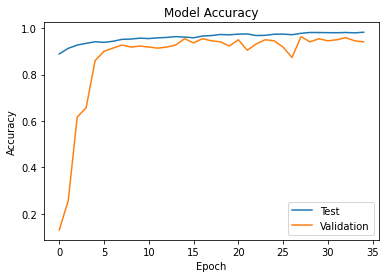

In [34]:
plt.plot(metricVals.history['accuracy'])
plt.plot(metricVals.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='lower right')
plt.show()

In [35]:
model.save("FaceMaskModel.h5")